In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
# VARIABLES
file_name = 'IC_raw_spectra_(2019_02_25_'

"""Sand"""
path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [4]:
# CODE

#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [5]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [6]:
#times_temps.drop(['Dummy'], axis = 1, inplace = True, errors = 'ignore')
times_temps['hc'] = np.nan #add empty 'hc' column

times_temps.loc[times_temps['Orientation'] == '270', 'hc'] = 'h'             #If 'Orientation'=270 degrees from nadir, then facing HBB
times_temps.loc[times_temps['Orientation'] == '225', 'hc'] = 'c'             #facing CBB
times_temps.loc[times_temps['Orientation'] == '20', 'hc'] = 'sand'           #sand view at 20 degrees from nadir
times_temps.loc[times_temps['Orientation'] == '160', 'hc'] = 'sky_sand'      #sky view for sand measurement
times_temps.loc[times_temps['Orientation'] == '55', 'hc'] = 'water'          #water view at 55 degrees from nadir
times_temps.loc[times_temps['Orientation'] == '125', 'hc'] = 'sky_water'     #sky view for water measurement

#columns_.pop(columns_.index('Time')) #Remove b from list
#columns_.pop(columns_.index('Orientation'))
#times_temps = times_temps[['Time']+columns_] #Create new dataframe with columns in the order you want

In [7]:
times_temps[700:730]

,RT0,RT1,RT2,Dummy,RT3,RT4,HBB_temp,CBB_temp,Time,Orientation,hc
700,21.820,21.150,21.330,850.000,22.350,22.440,69.970,28.810,58990,270,h
701,21.810,21.230,21.400,850.000,22.470,22.460,69.970,28.790,59014,270,h
702,21.930,21.280,21.430,850.000,22.670,22.820,69.960,28.790,59039,225,c
703,21.970,21.320,21.460,850.000,22.740,23.010,69.950,28.800,59064,225,c
704,21.970,21.290,21.440,850.000,22.710,22.920,69.960,28.810,59094,225,c
705,21.980,21.270,21.420,850.000,22.400,22.300,69.950,28.820,59119,225,c
706,21.970,21.240,21.400,850.000,22.620,22.310,69.960,28.820,59143,225,c
707,22.000,21.250,21.460,850.000,22.060,22.130,69.960,28.820,59166,225,c
708,21.670,21.170,21.460,850.000,22.290,22.300,69.970,28.810,59197,225,c
709,21.610,21.060,21.170,850.000,21.250,21.180,69.960,28.810,59220,225,c


In [8]:
water1cold, water2cold, water3cold, water4cold = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'180.txt')
water1hot, water2hot, water3hot, water4hot = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'191.txt')

#com,pare to spectra before and after
water1coldbefore, water2coldbefore, water3coldbefore, water4coldbefore = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'138.txt')
water1hotafter, water2hotafter, water3hotafter, water4hotafter = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'205.txt')

spec_cold = water2cold
spec_hot = water3hot 

spec_cold_before = water2coldbefore
spec_hot_after = water2hotafter 

wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


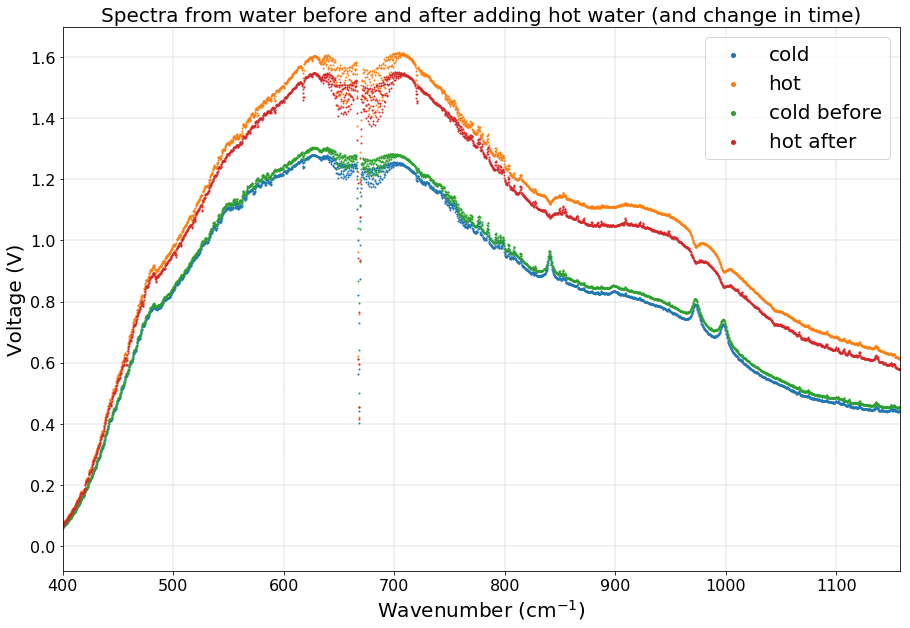

In [9]:
plt.figure(figsize=(15,10))
plt.scatter(wavenums, spec_cold, s=1)
plt.scatter(wavenums, spec_hot, s=1)
plt.scatter(wavenums, spec_cold_before, s=1)
plt.scatter(wavenums, spec_hot_after, s=1)
plt.title('Spectra from water before and after adding hot water (and change in time)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Voltage (V)', fontsize=20)
plt.legend(['cold', 'hot', 'cold before', 'hot after'], fontsize=20, markerscale=4)
plt.xlim(400,max(wavenums))
plt.tick_params(labelsize=16)
plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


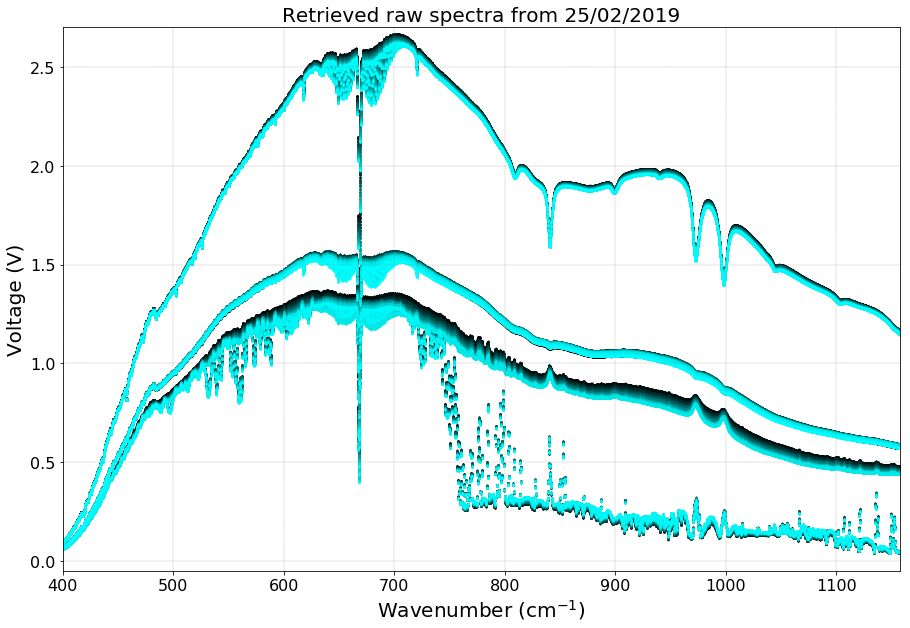

In [10]:
fig = plt.figure(figsize=(15,10))

index_range = np.arange(78*4,189*4)

for index in index_range:
    spec = read_raw_spectra(path_raw, files[int(np.floor(index/4))])[index%4]
    colour_ratio = (index-index_range[0])/(189*4-78*4)
    
    plt.scatter(wavenums, spec, s=1, c=(0,colour_ratio,colour_ratio))

    plt.title('Retrieved raw spectra from 25/02/2019', fontsize=20)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
    plt.ylabel('Voltage (V)', fontsize=20)
    plt.xlim(400, max(wavenums))
    plt.ylim(-0.05, 2.7)
    plt.tick_params(labelsize=16)
    plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

In [11]:
water_ind = []
skywater_ind = []
hbb_ind = []
cbb_ind = []

for index in np.arange(78*4,189*4):
    spec = read_raw_spectra(path_raw, files[int(np.floor(index/4))])[index%4]
    
    if 0.25<spec[-1]<0.5:
        water_ind.append(index)
    if spec[-1]<0.2:
        skywater_ind.append(index)
    if 0.5<spec[-1]<1:
        cbb_ind.append(index)
    if spec[-1]>1:
        hbb_ind.append(index)

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


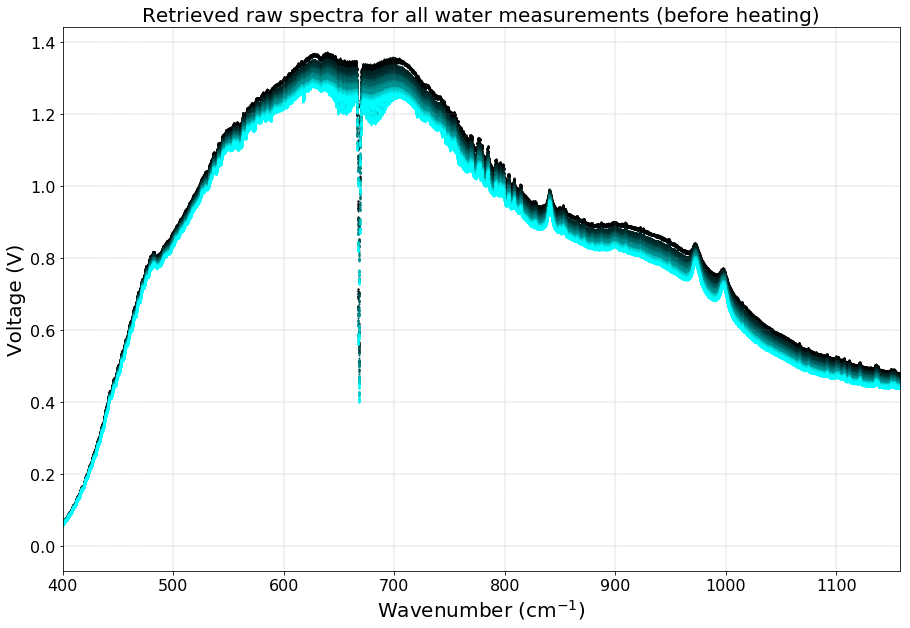

In [12]:
plt.figure(figsize=(15,10))

for index in water_ind:
    water_spec = read_raw_spectra(path_raw, files[int(np.floor(index/4))])[index%4]
    colour_ratio = (index-water_ind[0])/391
    
    plt.scatter(wavenums, water_spec, s=1, c=(0,colour_ratio,colour_ratio))
    plt.title('Retrieved raw spectra for all water measurements (before heating)', fontsize=20)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
    plt.ylabel('Voltage (V)', fontsize=20)
    plt.xlim(400, max(wavenums))
    plt.tick_params(labelsize=16)
    
    plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

In [13]:
wavenums_cut = [wn for wn in wavenums if wn>400]
wavenums_min_ind = [i for i,x in enumerate(wavenums) if x >400][0]

def inv_resp_function(hbb_index, cbb_index):
    
    hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
    cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
    V_diff = np.array(hbb_spectrum)-np.array(cbb_spectrum)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    temp_average_c = times_temps.at[cbb_index,'CBB_temp']

    radiances_avg_h = [planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut]
    radiances_avg_c = [planck(wn, float(temp_average_c)+273.15) for wn in wavenums_cut]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)

    def division(raw_val,planck_val):
        if raw_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div

    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)

    return(ratio)

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


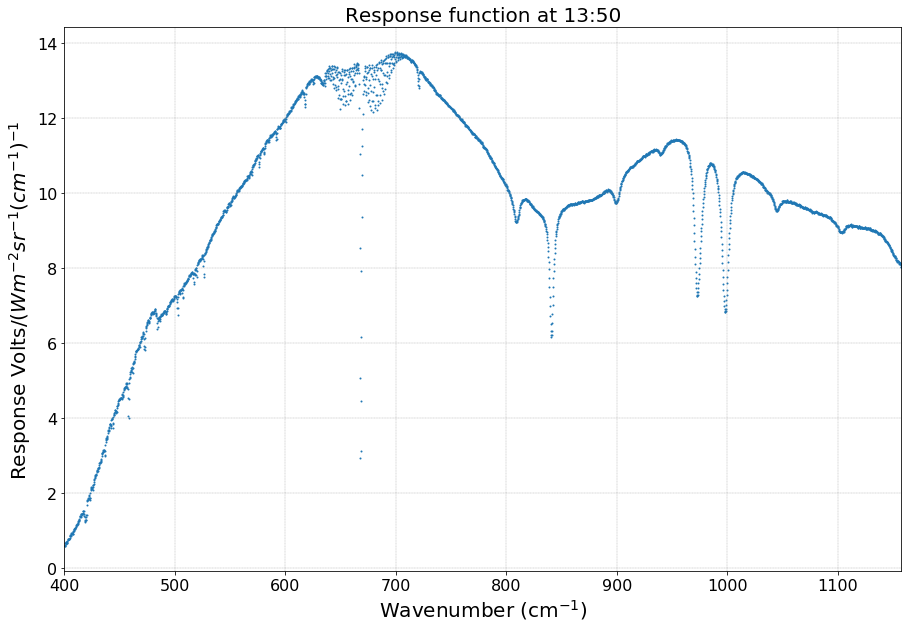

In [14]:
resp_test = inv_resp_function(343,344)

plt.figure(figsize=(15,10))
plt.scatter(wavenums_cut, resp_test, s=1)
plt.title('Response function at 13:50', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Response Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$', fontsize=20)
plt.xlim(400, max(wavenums))
plt.tick_params(labelsize=16)
plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


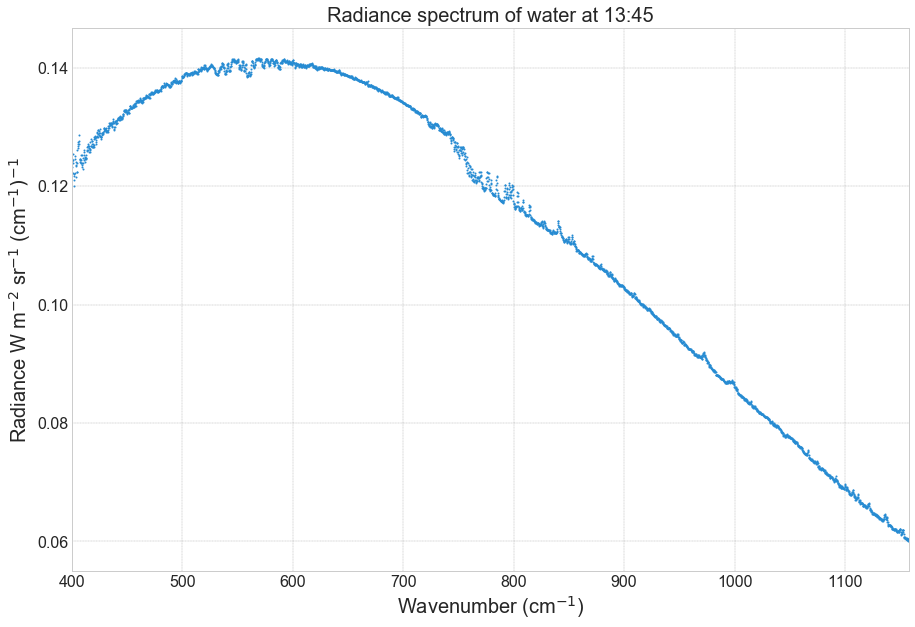

In [53]:
temp_average_h = times_temps.at[343,'HBB_temp']
hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(343/4))])[343%4][wavenums_min_ind:]

radiances_avg_h = np.array([planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut])
water_spectrum = read_raw_spectra(path_raw, files[int(np.floor(335/4))])[335%4][wavenums_min_ind:]

water_rad = np.divide((water_spectrum-hbb_spectrum), resp_test) + radiances_avg_h

plt.figure(figsize=(15,10))
plt.scatter(wavenums_cut, water_rad, s=1)
plt.title('Radiance spectrum of water at 13:45', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Radiance W m$^{-2}$ sr$^{-1}$ (cm$^{-1})^{-1}$', fontsize=20)
plt.xlim(400, max(wavenums))
plt.tick_params(labelsize=16)
plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

In [16]:
def plot_planck(temps):
    wavenums = np.arange(400,1200,0.5)
    plt.style.use(['Solarize_Light2', 'seaborn-whitegrid'])

    for t in temps:
        radiances = []
        for w in wavenums:
            radiances.append(planck(w, t+273.15))
        plt.plot(wavenums, radiances)
    plt.show()

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


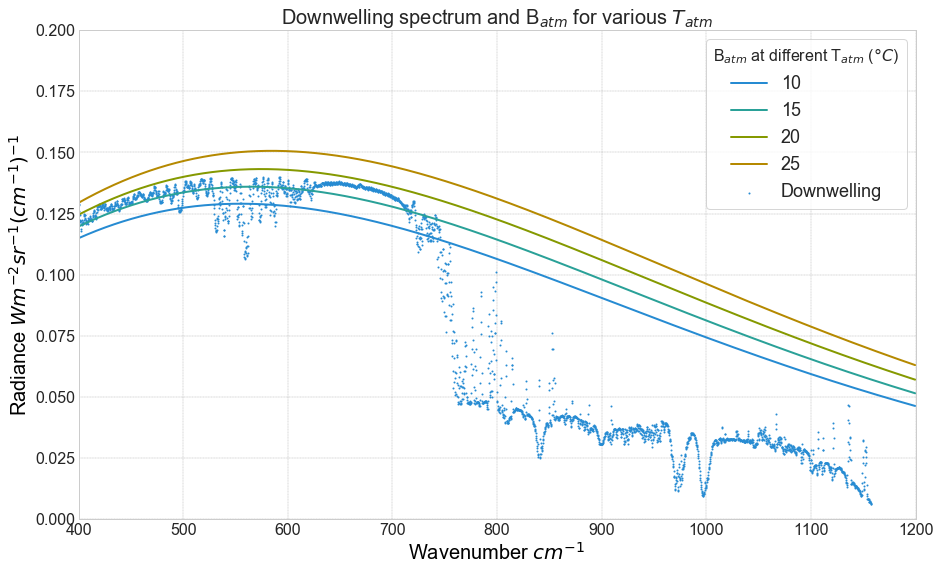

In [52]:
temp_average_h = times_temps.at[343,'HBB_temp']
hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(343/4))])[343%4][wavenums_min_ind:]
radiances_avg_h = np.array([planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut])

skywater_spectrum = read_raw_spectra(path_raw, files[int(np.floor(352/4))])[352%4][wavenums_min_ind:]

skywater_rad = np.divide((skywater_spectrum-hbb_spectrum), resp_test) + radiances_avg_h
temps = [10,15,20,25]
temps_label=[10,15,20,25,'Downwelling']

fig = plt.figure(figsize=(15,9), facecolor='white')

plt.scatter(wavenums_cut, skywater_rad, s=1)
plot_planck(temps)
plt.xlim(400,1200)
plt.ylim(0,0.2)
plt.xlabel(r'Wavenumber $cm^{-1}$', fontsize=20, color = 'black')
plt.ylabel(r'Radiance $W m^{-2} sr^{-1} (cm^{-1})^{-1}$', fontsize=20, color = 'black')
plt.tick_params(labelsize=16)
legend = plt.legend(temps_label, fontsize=18, title='B$_{atm}$ at different T$_{atm}$ ($\degree C$)', frameon=True)
plt.setp(legend.get_title(),fontsize=16)
plt.title('Downwelling spectrum and B$_{atm}$ for various $T_{atm}$', fontsize=20)

plt.grid(color='grey', linestyle='--', linewidth=.3)
plt.show()

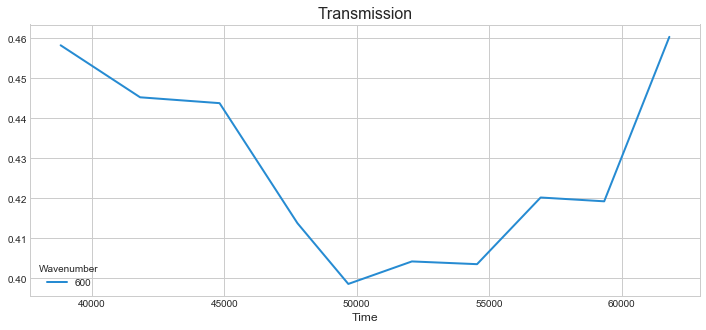

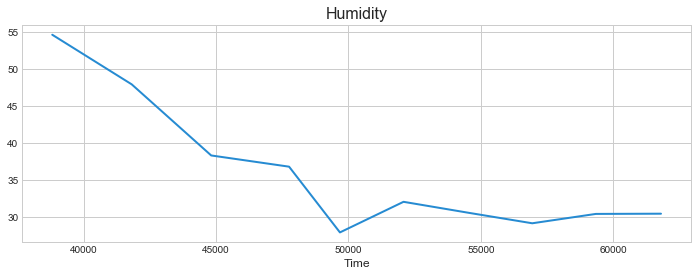

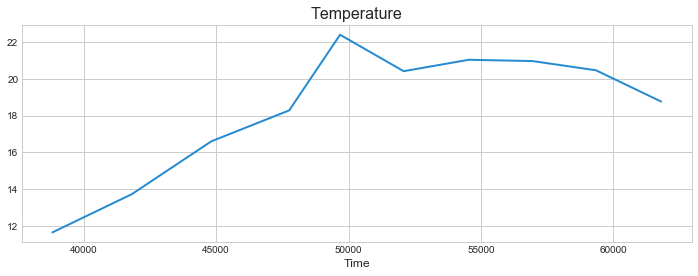

In [29]:
# get tau from Laura's files - need to interpolate for time and wavenum

file_path_tau = path_raw + "/Laura_simulations"

trans_times = [38820, 41820, 44820, 47760, 49680, 52080, 54540, 56940, 59340, 61800] #times in secs from midnight corresponding to simulations for certain humidity and temperature
trans_names = ['1165_5460', '1373_4792', '1660_3835', '1828_3684', '2239_2799', '2041_3211', '2103_3063', '2096_2922', '2046_3048', '1876_3051']


def get_transmission(wavenumber, time):
    """
    input: wavenumber and time
    output: atmospheric path transmission value given inputs
    """
    if time in trans_times:
        transmission = np.loadtxt(file_path_tau + '/' + trans_names[trans_times.index(time)] + '.txt')
        trans_wn = []
        trans_val = []
        for i in np.arange(transmission.shape[0]):
            if transmission[i][1] > 0.01:
                trans_wn.append(transmission[i][0])
                trans_val.append(transmission[i][1])
        f_trans = interpolate.interp1d(trans_wn, trans_val)
        tau = f_trans(wavenumber)
    else: #if time in between two transmission simulations, then interpolate between them
        idx1 = (np.abs(np.array(trans_times)-time)).argmin()
        if (np.abs(np.array(trans_times)-time)).min() > time:
            idx2 = idx1-1
        else:
            idx2 = idx1+1
            
        transmission1 = np.loadtxt(file_path_tau + '/' + trans_names[idx1] + '.txt')   
        transmission2 = np.loadtxt(file_path_tau + '/' + trans_names[idx2] + '.txt')  
        
        trans_wn1 = []
        trans_val1 = []
        for i in np.arange(transmission1.shape[0]):
            if transmission1[i][1] > 0.01:
                trans_wn1.append(transmission1[i][0])
                trans_val1.append(transmission1[i][1])
        trans_wn2 = []
        trans_val2 = []
        for i in np.arange(transmission2.shape[0]):
            if transmission2[i][1] > 0.01:
                trans_wn2.append(transmission2[i][0])
                trans_val2.append(transmission2[i][1])
                
        f_trans1 = interpolate.interp1d(trans_wn1, trans_val1)
        f_trans2 = interpolate.interp1d(trans_wn2, trans_val2)    
        tau1 = f_trans1(wavenumber)
        tau2 = f_trans2(wavenumber)

        tau = tau1 + (time-trans_times[idx1])/(trans_times[idx2]-trans_times[idx1])*(tau2-tau1)
        
    return tau


times_to_plot = np.linspace(39000,61000,10)
wns_to_plot = [600]

plt.figure(figsize=(12,5))
for wn in wns_to_plot:
    trans = []
    for time in trans_times:
        t = get_transmission(wn, time)
        trans.append(t)
    plt.plot(trans_times, trans)
plt.legend(wns_to_plot, title='Wavenumber')
plt.title('Transmission') 
plt.xlabel('Time')
plt.show()

humidities = [54.6, 47.92, 38.35, 36.84, 27.99, 32.11, 30.63, 29.22, 30.48, 30.51]
temperatures = [11.65, 13.73, 16.6, 18.28, 22.39, 20.41, 21.03, 20.96, 20.46, 18.76]

plt.figure(figsize=(12,4))
plt.plot(trans_times, humidities)
plt.title('Humidity')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(trans_times, temperatures)
plt.title('Temperature')
plt.xlabel('Time')
plt.show()

400.0742
400.3154
400.5565
400.7977
401.0388
401.28
401.5211
401.7623
402.0035
402.2446
402.4858
402.7269
402.9681
403.2092
403.4504
403.6915
403.9327
404.1739
404.415
404.6562
404.8973
405.1385
405.3796
405.6208
405.8619
406.1031
406.3442
406.5854
406.8265
407.0677
407.3088
407.55
407.7912
408.0323
408.2735
408.5146
408.7558
408.9969
409.2381
409.4792
409.7204
409.9615
410.2027
410.4438
410.685
410.9261
411.1673
411.4085
411.6496
411.8908
412.1319
412.3731
412.6142
412.8554
413.0965
413.3377
413.5789
413.82
414.0612
414.3023
414.5435
414.7846
415.0258
415.2669
415.5081
415.7492
415.9904
416.2315
416.4727
416.7138
416.955
417.1962
417.4373
417.6785
417.9196
418.1608
418.4019
418.6431
418.8842
419.1254
419.3665
419.6077
419.8488
420.09
420.3311
420.5723
420.8135
421.0546
421.2958
421.5369
421.7781
422.0192
422.2604
422.5015
422.7427
422.9839
423.225
423.4662
423.7073
423.9485
424.1896
424.4308
424.6719
424.9131
425.1542
425.3954
425.6365
425.8777
426.1188
426.36
426.6012
426.8423
427.08

622.9004
623.1415
623.3827
623.6238
623.865
624.1061
624.3473
624.5884
624.8296
625.0708
625.312
625.5531
625.7943
626.0354
626.2766
626.5177
626.7589
627.0
627.2411
627.4823
627.7234
627.9646
628.2057
628.447
628.6881
628.9293
629.1704
629.4116
629.6527
629.8939
630.135
630.3762
630.6173
630.8585
631.0996
631.3408
631.5819
631.8231
632.0643
632.3054
632.5466
632.7877
633.0289
633.27
633.5112
633.7523
633.9935
634.2346
634.4758
634.7169
634.9581
635.1992
635.4404
635.6816
635.9227
636.1639
636.405
636.6462
636.8873
637.1285
637.3696
637.6108
637.8519
638.0931
638.3342
638.5754
638.8165
639.0577
639.2989
639.54
639.7812
640.0223
640.2635
640.5046
640.7458
640.9869
641.2281
641.4692
641.7104
641.9515
642.1927
642.4338
642.675
642.9161
643.1573
643.3985
643.6396
643.8808
644.1219
644.3631
644.6042
644.8454
645.0865
645.3277
645.5688
645.81
646.0511
646.2923
646.5334
646.7746
647.0158
647.257
647.4981
647.7393
647.9804
648.2216
648.4627
648.7039
648.945
649.1862
649.4273
649.6685
649.9096


845.9677
846.2089
846.45
846.6912
846.9323
847.1735
847.4146
847.6558
847.8969
848.1381
848.3792
848.6204
848.8616
849.1027
849.3439
849.585
849.8262
850.0673
850.3085
850.5496
850.7908
851.0319
851.2731
851.5142
851.7554
851.9965
852.2377
852.4789
852.72
852.9612
853.2023
853.4435
853.6846
853.9258
854.1669
854.4081
854.6492
854.8904
855.1315
855.3727
855.6138
855.855
856.0962
856.3373
856.5785
856.8196
857.0608
857.3019
857.5431
857.7842
858.0254
858.2665
858.5077
858.7488
858.99
859.2311
859.4723
859.7134
859.9547
860.1958
860.437
860.6781
860.9193
861.1604
861.4016
861.6427
861.8839
862.125
862.3661
862.6073
862.8484
863.0896
863.3307
863.572
863.8131
864.0543
864.2954
864.5366
864.7777
865.0189
865.26
865.5012
865.7423
865.9835
866.2246
866.4658
866.707
866.9481
867.1893
867.4304
867.6716
867.9127
868.1539
868.395
868.6362
868.8773
869.1185
869.3596
869.6008
869.8419
870.0831
870.3242
870.5654
870.8066
871.0477
871.2889
871.53
871.7712
872.0123
872.2535
872.4946
872.7358
872.9769


1062.2827
1062.5238
1062.765
1063.0062
1063.2473
1063.4885
1063.7296
1063.9708
1064.2119
1064.4531
1064.6942
1064.9354
1065.1765
1065.4177
1065.6588
1065.9
1066.1411
1066.3823
1066.6235
1066.8646
1067.1058
1067.3469
1067.5881
1067.8292
1068.0704
1068.3115
1068.5527
1068.7938
1069.035
1069.2761
1069.5173
1069.7584
1069.9996
1070.2407
1070.4819
1070.7231
1070.9642
1071.2054
1071.4465
1071.6877
1071.9288
1072.17
1072.4111
1072.6523
1072.8934
1073.1346
1073.3757
1073.6169
1073.858
1074.0992
1074.3405
1074.5815
1074.8228
1075.0638
1075.3051
1075.5461
1075.7874
1076.0284
1076.2697
1076.5107
1076.752
1076.993
1077.2343
1077.4753
1077.7166
1077.9578
1078.1989
1078.4401
1078.6812
1078.9224
1079.1635
1079.4047
1079.6458
1079.887
1080.1281
1080.3693
1080.6104
1080.8516
1081.0927
1081.3339
1081.5751
1081.8162
1082.0574
1082.2985
1082.5397
1082.7808
1083.022
1083.2631
1083.5043
1083.7454
1083.9866
1084.2277
1084.4689
1084.71
1084.9512
1085.1923
1085.4335
1085.6747
1085.9158
1086.157
1086.3981
1086.

ValueError: x and y must have same first dimension, but have shapes (3142,) and (11,)

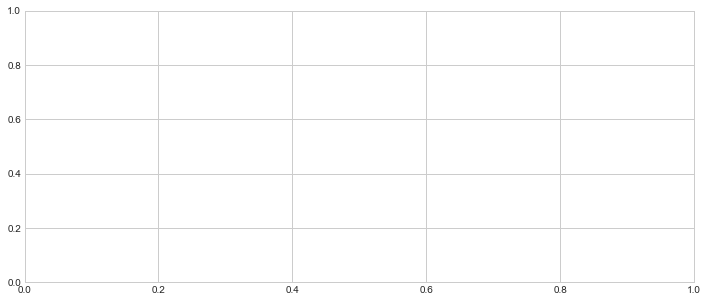

In [35]:
time_plot = 49740
wns_to_plot = wavenums_cut

plt.figure(figsize=(12,5))

taus=[]
for wn in wns_to_plot:
    print(wn)
    t = get_transmission(wn,time_plot)
    taus.append(t)
plt.plot(wns_to_plot, trans)
plt.legend(wns_to_plot, title='Wavenumber')
plt.title('Transmission') 
plt.xlabel('Wavenumber cm$^{-1}$')
plt.show()

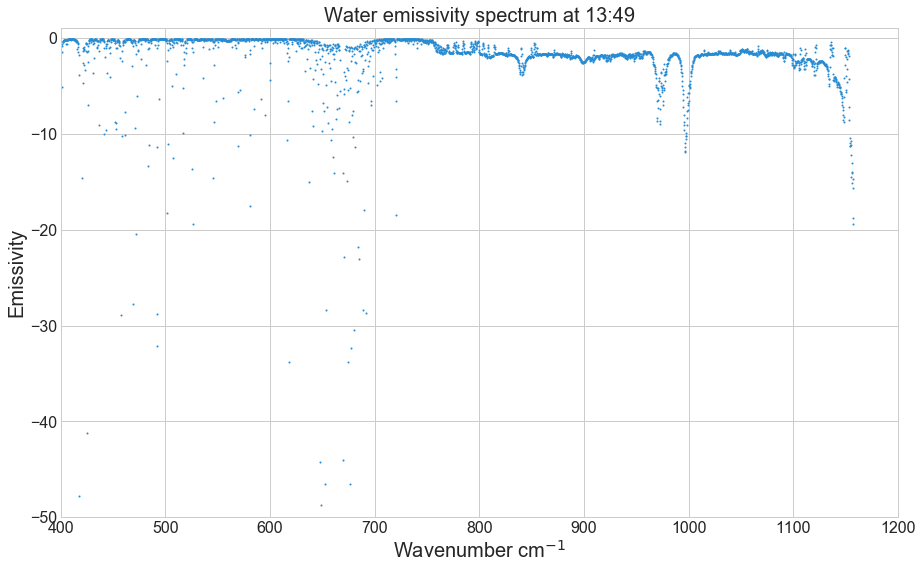

In [70]:
def calculate_emissivity(L_up, L_down, T_atm, T_surf, tau, wn):

    B_atm = planck(T_atm, wn)
    B_surf = planck(T_surf, wn)
    N = L_up - (tau**2)*L_down - (1-tau**2)*B_atm
    D = tau*(B_surf - tau*L_down - (1-tau)*B_atm)
    return N/D

emissivity_vec = np.vectorize(calculate_emissivity)

ems = emissivity_vec(water_rad, skywater_rad, 20, 19.2, taus, wavenums_cut)
fig = plt.figure(figsize=(15,9))
plt.scatter(wavenums_cut, ems, s=1)
plt.xlim(400,1200)
plt.ylim(-50,1)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=20)
plt.title('Water emissivity spectrum at 13:49', fontsize=20)
plt.tick_params(labelsize=16)
plt.show()

Text(0.5,1,'Transmission spectrum at 13:49')

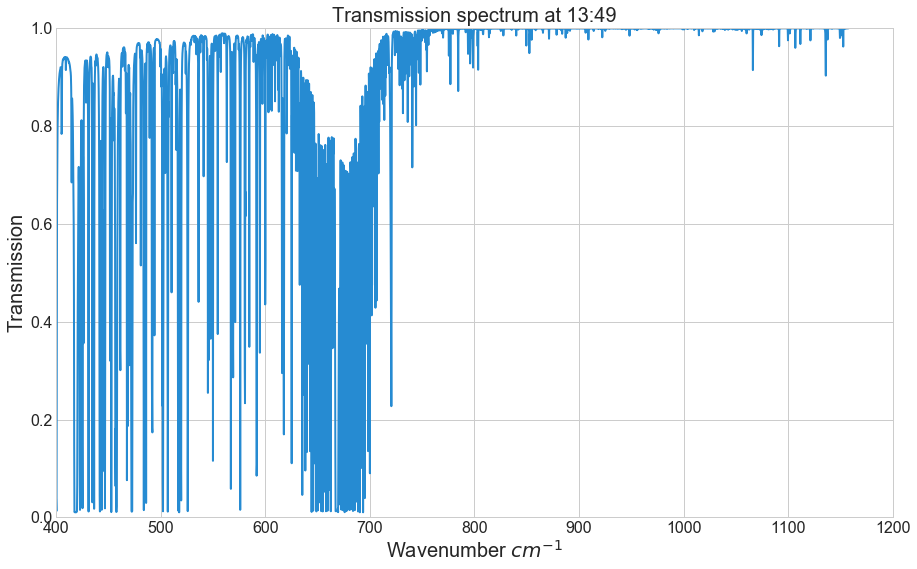

In [68]:
fig=plt.figure(figsize=(15,9))
plt.plot(wavenums_cut,taus)
plt.xlim(400,1200)
plt.ylim(0,1)
plt.xlabel('Wavenumber $cm^{-1}$', fontsize=20)
plt.ylabel('Transmission', fontsize=20)
plt.tick_params(labelsize=16)
plt.title('Transmission spectrum at 13:49', fontsize=20)